# Preprocessing data

In [23]:
# importing dependencies
import pandas as pd
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint

In [24]:
from google.colab import files
uploaded = files.upload()

Saving charity_data.csv to charity_data (1).csv


In [25]:
# reading in data
import io
application_df = pd.read_csv(io.BytesIO(uploaded['charity_data.csv']))
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [26]:
# dropping "EIN", "NAME", "APPLICATION_TYPE" since non beneficial
application_df = application_df.drop(columns=['EIN', 'NAME'])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [27]:
# checking for number of unique values per variable
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [28]:
# determining value counts for binning APPLICATION_TYPE column
app_count = application_df.APPLICATION_TYPE.value_counts()
app_count

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

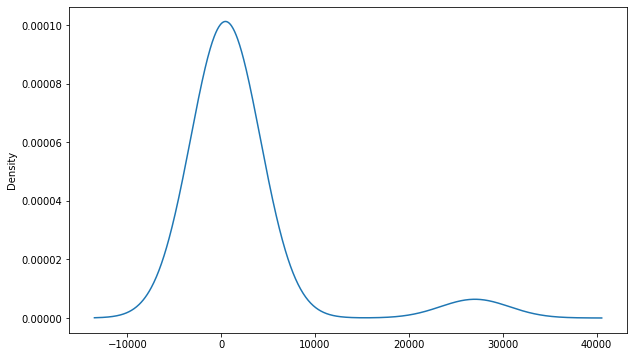

In [29]:
# plotting density of app_count
app_count.plot.density(figsize=(10,6))

In [30]:
# determining values to replace if counts are less than 500
replace_application = list(app_count[app_count < 500].index)

# replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,'other')

# checking if binning established
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
other      276
Name: APPLICATION_TYPE, dtype: int64

In [31]:
# determining value counts for binning CLASSIFICATION column
class_count = application_df.CLASSIFICATION.value_counts()
class_count

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C2170        1
C2570        1
C1820        1
C1580        1
C1570        1
Name: CLASSIFICATION, Length: 71, dtype: int64

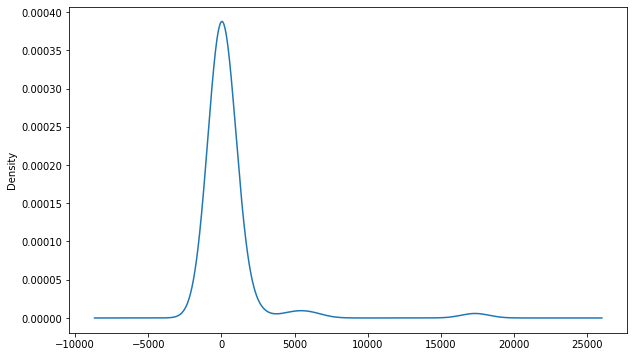

In [32]:
# plotting density of class_count
class_count.plot.density(figsize=(10,6))

In [33]:
# determining values to replace if counts less than 1000
replace_class = list(class_count[class_count < 1000].index)

# replacing in dataframe and categorizing under 'other'
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,'other')

# checking if binning established
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [34]:
# creating categorical variable list
application_cat = application_df.dtypes[application_df.dtypes =='object'].index.tolist()

In [35]:
# initiating OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# fit and transform OneHotEncoder using categorical list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# add encoded variable to dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,APPLICATION_TYPE_other,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
# merging encoded features to original dataframe and dropping columns
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,APPLICATION_TYPE_other,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_other,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
# naming target and feature variables from preprocessed data
y = application_df.IS_SUCCESSFUL
X = application_df.drop(columns=['IS_SUCCESSFUL'])

# splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
# initiate standardscaler instance
scaler = StandardScaler()

# fit standardscaler
X_scaler = scaler.fit(X_train)

# scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [39]:
# creating method to create sequential model with hyperparameter options
def create_model(hp):
  nn_model = tf.keras.models.Sequential()

  # kerastuner to select activation function for hidden layers
  activation = hp.Choice('activation',['relu','tanh','sigmoid'])

  # kerastuner to select number of neurons for first layer
  nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
                min_value=1, max_value=80, step=2), 
                activation=activation, input_dim=len(X_train_scaled[0])))
  
  # kerasturner to select number of hidden layers and neurons for each
  for i in range(hp.Int('num_layers',1, 6)):
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                 min_value=1, max_value=40, step=2),
                 activation=activation))
  
  # output layer
  nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  # compiling the model
  nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return nn_model


In [41]:
# importing kerastuner library
import kerastuner as kt

tuner = kt.Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=80,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


In [42]:
# running kerastuner search for best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=80,validation_data=(X_test_scaled, y_test))

Trial 136 Complete [00h 02m 08s]
val_accuracy: 0.7318950295448303

Best val_accuracy So Far: 0.73399418592453
Total elapsed time: 01h 18m 11s
INFO:tensorflow:Oracle triggered exit


In [43]:
# get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 71,
 'num_layers': 4,
 'tuner/bracket': 3,
 'tuner/epochs': 27,
 'tuner/initial_epoch': 9,
 'tuner/round': 2,
 'tuner/trial_id': 'e0922d2fd04f461ecf133421e787a938',
 'units_0': 35,
 'units_1': 7,
 'units_2': 5,
 'units_3': 19,
 'units_4': 15,
 'units_5': 9}

In [44]:
# evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

268/268 - 0s - loss: 0.5522 - accuracy: 0.7340
Loss: 0.5521790385246277, Accuracy: 0.73399418592453
